<a href="https://colab.research.google.com/github/thiagolermen/facemask-detection-v1/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Mask Detection

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing mask or not wearing them..
This dataset contains 3797 images belonging to the 2 classes.
The classes are:

- With mask;
- Without mask;


##Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

###Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Path to Kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/facemask-detection
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle/facemask-detection


##Dataset

In [5]:
# Checking the file
!ls

with1.jpg   with4.jpg	  without2.jpg	without5.jpg	y_train.pickle
with2.jpg   with_mask	  without3.jpg	without_mask
with3.jpeg  without1.jpg  without4.jpg	X_train.pickle


In [6]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [7]:
import pathlib

dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/"

mask_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/with_mask/"
mask_dir = pathlib.Path(mask_dir)

no_mask_dir = "/content/gdrive/My Drive/Kaggle/facemask-detection/without_mask/"
no_mask_dir = pathlib.Path(no_mask_dir)

classes = ["with_mask", "without_mask"]


Counting the number of files

In [8]:
mask_count = len(list(mask_dir.glob('*.*')))
no_mask_count = len(list(no_mask_dir.glob('*.*')))
print(f"Number of images with mask: {mask_count} \nNumber of images without mask: {no_mask_count}")

Number of images with mask: 1884 
Number of images without mask: 1913


###Visualizing the dataset

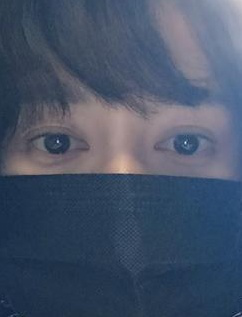

In [9]:
mask = list(mask_dir.glob('*'))
PIL.Image.open(str(mask[0]))

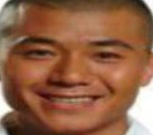

In [10]:
no_mask = list(no_mask_dir.glob('*'))
PIL.Image.open(str(no_mask[0]))

##Creating training data

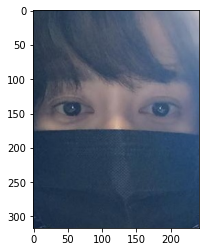

In [11]:
for category in classes:
  path = os.path.join(dir, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.show
    break
  break

###Preprocessing data

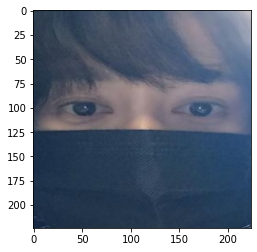

In [12]:
img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))

####Reading the images and converting all to array

In [13]:
training_data = [] # data

def create_training_data():
  for category in classes:
    path = os.path.join(dir, category)
    class_num = classes.index(category) # 0,1 -> labels
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_array, class_num]) # [[img, label]]
      except Exception as e:
        pass

In [14]:
create_training_data()

In [15]:
print(f"Training data size: {len(training_data)}")

Training data size: 3797


In [16]:
import random

random.shuffle(training_data)

In [17]:
X_train = [] # data
y_train = [] # label

# Create a numpy array with all the features
for features, label in training_data:
  X_train.append(features)
  y_train.append(label)

X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)

In [18]:
X_train.shape

(3797, 224, 224, 3)

In [19]:
# Normalize the data
X_train = X_train/255.0

In [20]:
# Create a numpy array with all the labels
y_train = np.array(y_train)

Import/Export data

In [ ]:
# Export data
#import pickle

#pickle_out = open("X_train.pickle", "wb")
#pickle.dump(X_train, pickle_out, protocol=4)
#pickle_out.close()

#pickle_out = open("y_train.pickle", "wb")
#pickle.dump(y_train, pickle_out, protocol=4)
#pickle_out.close()

In [ ]:
# Import data
# pickle_in = open("X_train.pickle", "rb")
# X_train = pickle.load(pickle_in)

# pickle_in = open("y_train.pickle", "rb")
# y_train = pickle.load(pickle_in)

##Creating the model

Pretrained model:

In [190]:
model = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
model.summary()

####Fine tuning

In [192]:
base_input = model.layers[0].input # the model starts at the pretrained model's first layer

In [193]:
base_output = model.layers[-4].output # cuts at the pretraining model's dropout layer

In [194]:
flatten_layer = layers.Flatten()(base_input) # connect this layer with base_input
final_output = layers.Dense(1)(flatten_layer) # connect with flatten_layer
                                              # the model classifies in 1 or 0 (with or without mask)
final_output = layers.Activation('sigmoid')(final_output) # add an activation function to the dense layer

In [195]:
new_model = keras.Model(inputs = base_input, outputs=final_output)

In [196]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 150529    
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 150,529
Trainable params: 150,529
Non-trainable params: 0
_________________________________________________________________


##Compile the model

In [197]:
new_model.compile(loss = "binary_crossentropy", 
                  optimizer="adam",
                  metrics = ["accuracy"])

##Training the model

In [198]:
epochs = 40
history = new_model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/40
95/95 [==============================] - 4s 36ms/step - loss: 5.6337 - accuracy: 0.6614 - val_loss: 0.4404 - val_accuracy: 0.8737
Epoch 2/40
95/95 [==============================] - 2s 16ms/step - loss: 0.8536 - accuracy: 0.8296 - val_loss: 1.0350 - val_accuracy: 0.7974
Epoch 3/40
95/95 [==============================] - 2s 16ms/step - loss: 0.6289 - accuracy: 0.8804 - val_loss: 1.0578 - val_accuracy: 0.7974
Epoch 4/40
95/95 [==============================] - 2s 16ms/step - loss: 1.0503 - accuracy: 0.8313 - val_loss: 1.2128 - val_accuracy: 0.8211
Epoch 5/40
95/95 [==============================] - 2s 16ms/step - loss: 1.0015 - accuracy: 0.8571 - val_loss: 0.3628 - val_accuracy: 0.9289
Epoch 6/40
95/95 [==============================] - 2s 16ms/step - loss: 0.4403 - accuracy: 0.9200 - val_loss: 0.4756 - val_accuracy: 0.9066
Epoch 7/40
95/95 [==============================] - 2s 16ms/step - loss: 0.6073 - accuracy: 0.8840 - val_loss: 0.8617 - val_accuracy: 0.8724
Epoch 8/40
95

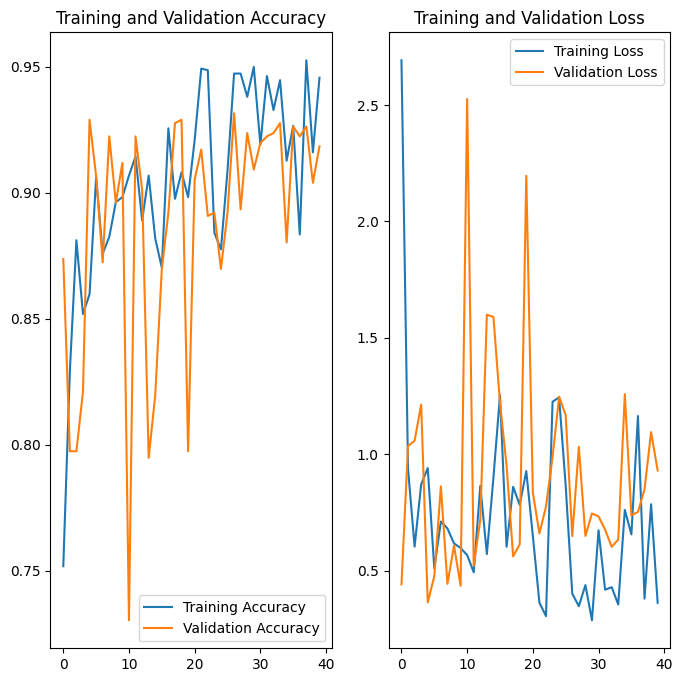

In [199]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Predictions

In [200]:
def preprocess_prediction(file_name):
  frame = cv2.imread(file_name)
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  final_image = cv2.resize(frame, (224,224))
  final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
  final_image = final_image/255.0
  predictions = new_model.predict(final_image)
  if predictions[0] < 0.5:
    print("With mask")
  else:
    print("Without mask")

With mask


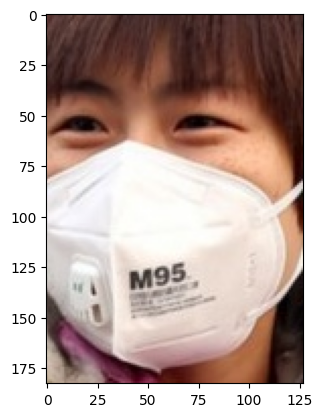

In [201]:
preprocess_prediction('with1.jpg')

With mask


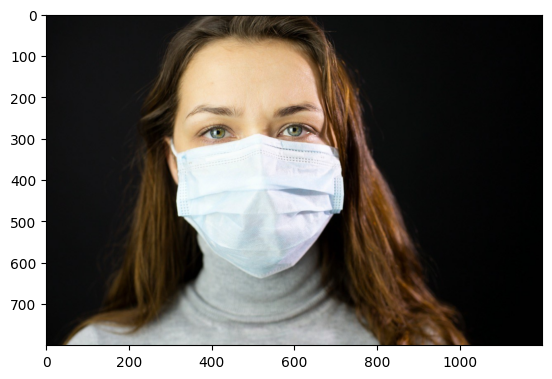

In [202]:
preprocess_prediction('with2.jpg')

Without mask


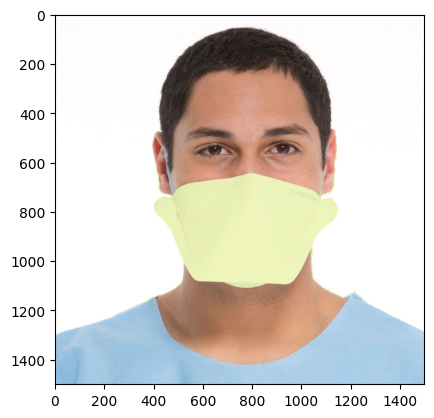

In [203]:
preprocess_prediction('with3.jpeg')

With mask


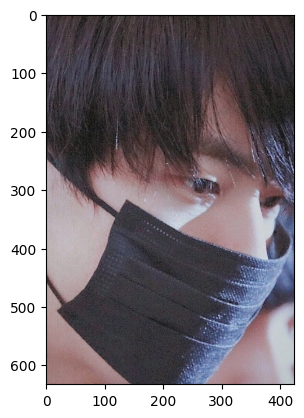

In [204]:
preprocess_prediction('with4.jpg')

Without mask


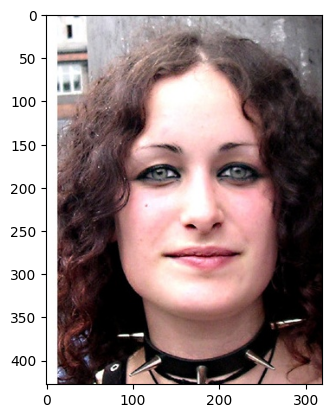

In [205]:
preprocess_prediction('without1.jpg')

Without mask


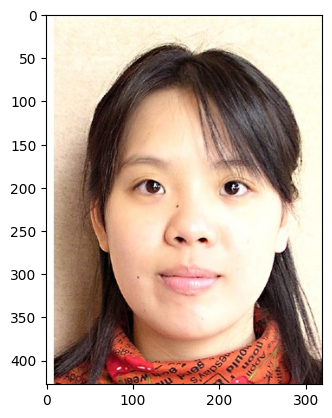

In [206]:
preprocess_prediction('without2.jpg')

Without mask


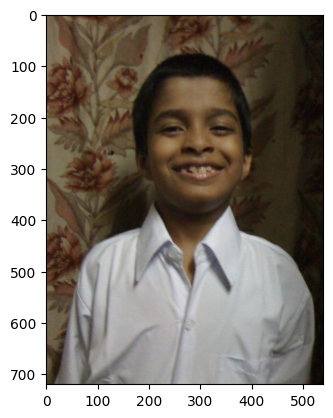

In [207]:
preprocess_prediction('without3.jpg')

Without mask


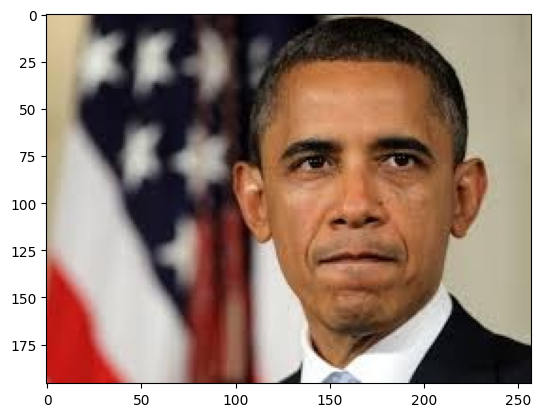

In [208]:
preprocess_prediction('without4.jpg')

Without mask


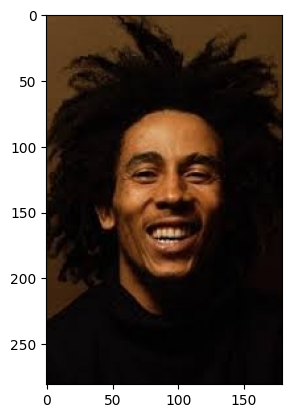

In [209]:
preprocess_prediction('without5.jpg')

###Face detection

We're going to use [Haar Cascade Face Detection](https://github.com/opencv/opencv/tree/master/data/haarcascades) by OpenCV

The model predicted wrongly

Without mask


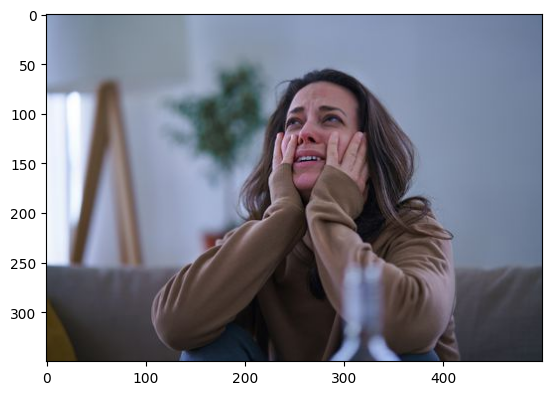

In [210]:
preprocess_prediction('without6.jpg')

Find faces in the image

In [211]:
def face_detection(frame):
  # Choose the object detection classifier - in this case haar cascade
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  # Face detection and cropping
  faces = faceCascade.detectMultiScale(gray,1.1,4)
  for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
    new_faces = faceCascade.detectMultiScale(roi_gray)
    if len(new_faces) == 0:
      print("Face not detected")
      break
    else:
      for (ex,ey,ew,eh) in new_faces:
        face_roi = roi_color[ey: ey+eh, ex:ex+ew]
        cropped_face = face_roi
  # Plot two images
  fig, axs = plt.subplots(2)
  fig.suptitle('Face detection x Cropped face')
  axs[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  axs[1].imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
  
  return cropped_face, frame

####Predictions using face detection

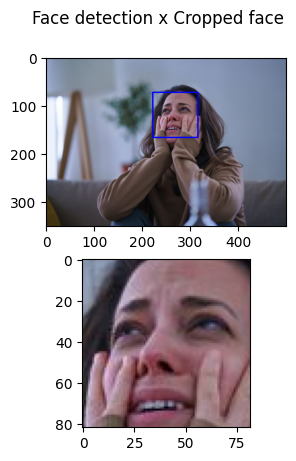

In [212]:
# Face detection
frame = cv2.imread('without6.jpg')
cropped_face = face_detection(frame)[0]

Now, the model predicted correctly

Without mask


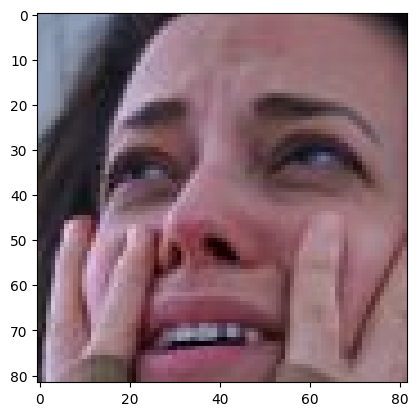

In [213]:
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(cropped_face, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")

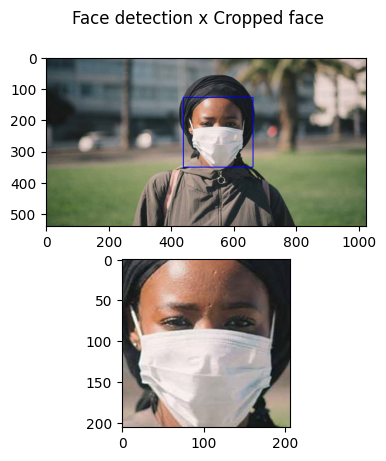

In [214]:
# Face detection
frame = cv2.imread('with6.jpg')
cropped_face = face_detection(frame)[0]

With mask


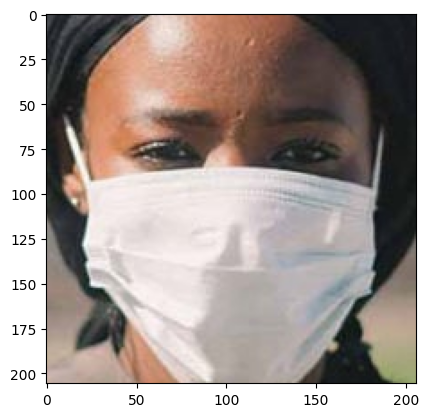

In [215]:
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
final_image = cv2.resize(cropped_face, (224,224))
final_image = np.expand_dims(final_image, axis=0) # needs fourth dimension
final_image = final_image/255.0
predictions = new_model.predict(final_image)
if predictions[0] < 0.5:
  print("With mask")
else:
  print("Without mask")